# Assignment 1: Introduction to the Fully Recurrent Network

*Author:* Thomas Adler

*Copyright statement:* This  material,  no  matter  whether  in  printed  or  electronic  form,  may  be  used  for  personal  and non-commercial educational use only.  Any reproduction of this manuscript, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.


## Exercise 1: Numerical stability of the binary cross-entropy loss function

We will use the binary cross-entropy loss function to train our RNN, which is defined as 
$$
L_{\text{BCE}}(\hat y, y) = -y \log \hat y - (1-y) \log (1-\hat y),
$$
where $y$ is the label and $\hat y$ is a prediction, which comes from a model (e.g. an RNN) and is usually sigmoid-activated, i.e., we have
$$
\hat y = \sigma(z) = \frac{1}{1+e^{-z}}.
$$
The argument $z$ is called *logit*. For reasons of numerical stability it is better to let the model emit the logit $z$ (instead of the prediction $\hat y$) and incorporate the sigmoid activation into the loss function. Explain why this is the case and how we can gain numerical stability by combining the two functions $L_{\text{BCE}}(\hat y, y)$ and $\sigma(z)$ into one function $L(z, y) = L_{\text{BCE}}(\sigma(z), y)$. 

*Hint: Prove that $\log(1+e^{z}) = \log (1+e^{-|z|}) + \max(0, z)$ and argue why the right-hand side is numerically more stable. Finally, express $L(z,y)$ in terms of that form.*

########## YOUR SOLUTION HERE ##########

Indeed, we only need to know some basic logarithm rules and $1-\sigma(z) = \sigma(-z)$ to prove the hint. We get

\begin{aligned}
    - y \log \hat y - (1 - y) \log (1- \hat y) &= - y \log \sigma(z) - (1 - y) \log (1 - \sigma(z)) \\
    &= -y \log 1 + y \log \left(1 + e^{-z}\right) - (1-y) \log \left( -\sigma(z) \right)\\
    &= y \log \left( 1 + e^{-z} \right) - (1-y) \log 1 + (1-y) \log \left( 1 + e^{z} \right)\\
    &= y \log \left( 1 + e^{-z} \right) + (1-y) \log \left( 1 + e^{z} \right)\\
    &= y \log \left( 1+e^{-z} \right) + (1-y) \left( \log \left[ 1+e^{-\lvert z \rvert} \right] + \max(0, z) \right)
\end{aligned}

where we used the identity $\log(1+e^{z}) = \log (1+e^{-|z|}) + \max(0, z)$ in the last step. We will show this identity now.

Let $z > 0$. Then we have
\begin{aligned}
    \log(1+e^{z}) &= \log \left( e^z \left[ 1+e^{-z} \right] \right)\\
    &= \log e^z + \log \left( 1+e^{-z} \right)\\
    &= z + \log \left( 1+e^{-z} \right)\\
    &= \max (0, z) + \log \left( 1+e^{-\lvert z \rvert} \right).
\end{aligned}
Let $z \leq 0$. Then $\log (1+e^z) = \log \left(1+e^{-\lvert z \rvert}\right) + \max (0, z)$ trivially.


Numerical Stability. Let $z \in \mathbb{R}$ be large. Then, in order to calculate $\log(1+e^{z})$, we need to calculate $e^{z}$ first. If $z$ is large, then $e^{z}$ will be very large and might lead to overflow. This does not happen with $e^{- \lvert z \rvert}$.

## Exercise 2: Derivative of the loss

Calculate the derivative of the binary cross-entropy loss function $L(z, y)$ with respect to the logit $z$.

########## YOUR SOLUTION HERE ##########
We get
\begin{aligned}
    L(z, y) &= -y \log \left( 1+e^{-z} \right) + (1-y) \log \left( 1+e^z \right).
\end{aligned}
Hence we get for the derivative
\begin{aligned}
    \frac{\partial L(z, y)}{\partial z} &= \frac{-y e^{-z}}{1+e^{-z}} + \frac{(1-y)e^z}{1+e^{z}}\\
    &= (1-y) \sigma(z) - y \sigma(-z)
\end{aligned}
due to the definition of the sigmoid function $\sigma(z) = \frac{1}{1+e^{-z}} = \frac{e^z}{1+e^z}$.

## Exercise 3: Initializing the network
Consider the fully recurrent network
$$
s(t) = W x(t) + R a(t-1) \\
a(t) = \tanh(s(t)) \\
z(t) = V a(t) \\
\hat y(t) = \sigma(z(t))
$$
for $t \in \mathbb{N}, x(t) \in \mathbb{R}^{D}, s(t) \in \mathbb{R}^{I}, a(t) \in \mathbb{R}^{I}, z(t) \in \mathbb{R}^K, \hat y(t) \in \mathbb{R}^K$ and $W, R, V$ are real matrices of appropriate sizes and $\hat a(0) = 0$. 

*Compared to the lecture notes we choose $f(x) = \tanh(x) = (e^x - e^{-x})(e^x + e^{-x})^{-1}$ and $\varphi(x) = \sigma(x) = (1+e^{-x})^{-1}$. Further, we introduced an auxiliary variable $z(t)$ and transposed the weight matrices.*

Write a function `init` that takes a `model` and integers $D, I, K$ as arguments and stores the matrices $W, R, V$ as members `model.W`, `model.R`, `model.V`, respectively. The matrices should be `numpy` arrays of appropriate sizes and filled with random values that are uniformly distributed between -0.01 and 0.01. 

In [19]:
%matplotlib inline
import numpy as np
from scipy.special import expit as sigmoid

class Obj(object):
    pass

model = Obj()
T, D, I, K = 10, 3, 5, 1

def init(model, D, I, K): # Shapes from Script, p. 25
    model.W = np.random.uniform(low=-0.01, high=0.01, size=(D, I))
    model.R = np.random.uniform(low=-0.01, high=0.01, size=(I, I))
    model.V = np.random.uniform(low=-0.01, high=0.01, size=(I, K))

Obj.init = init
model.init(D, I, K)

## Exercise 4: The forward pass
Implement the forward pass for the fully recurrent network for sequence classification (many-to-one mapping). To this end, write a function `forward` that takes a `model`, a sequence of input vectors `x`, and a label `y` as arguments. The inputs will be represented as a `numpy` array of shape `(T, D)`. It should execute the behavior of the fully recurrent network and evaluate the (numerically stabilized) binary cross-entropy loss at the end of the sequence and return the resulting loss value. Store the sequence of hidden activations $(a(t))_{t=1}^T$ and the logit $z(T)$ into `model.a` and `model.z`, respectively. 

In [20]:
def forward(model, x, y):
    ########## YOUR SOLUTION HERE ##########
    
    T = x.shape[0]
    I = model.W.shape[1]
    model.a = np.zeros((I, T))
    a = np.zeros((I))
    for t in range(T):
        s = model.W.T @ x[t].T + model.R.T @ a
        a = 2 * sigmoid(2 * s) - 1 # tanh
        model.a[:, t] = a
    model.z = model.V.T @ model.a # K x T
    loss = y * np.log(1+np.exp(-model.z)) + (1-y) * (
        np.log(1+np.exp(-np.abs(model.z))) + np.maximum(model.z, 0) # We use the stable loss here
    )
    return loss

Obj.forward = forward
model.forward(np.random.uniform(-1, 1, (T, D)), 1)

array([[0.69318019, 0.69310049, 0.69310778, 0.69311408, 0.69313981,
        0.69315102, 0.6930748 , 0.69317111, 0.69318945, 0.69314982]])

## Exercise 5: The computational graph

Visualize the computational graph of the fully recurrent network unfolded in time. The graph should show the functional dependencies of the nodes $x(t), a(t), z(t), L(z(t), y(t))$ for $t \in \{1, 2, 3\}$. Use the package `networkx` in combination with `matplotlib` to draw a directed graph with labelled nodes and edges. If you need help take a look at [this guide](https://networkx.org/documentation/stable/tutorial.html). Make sure to arrange the nodes in a meaningful way. 

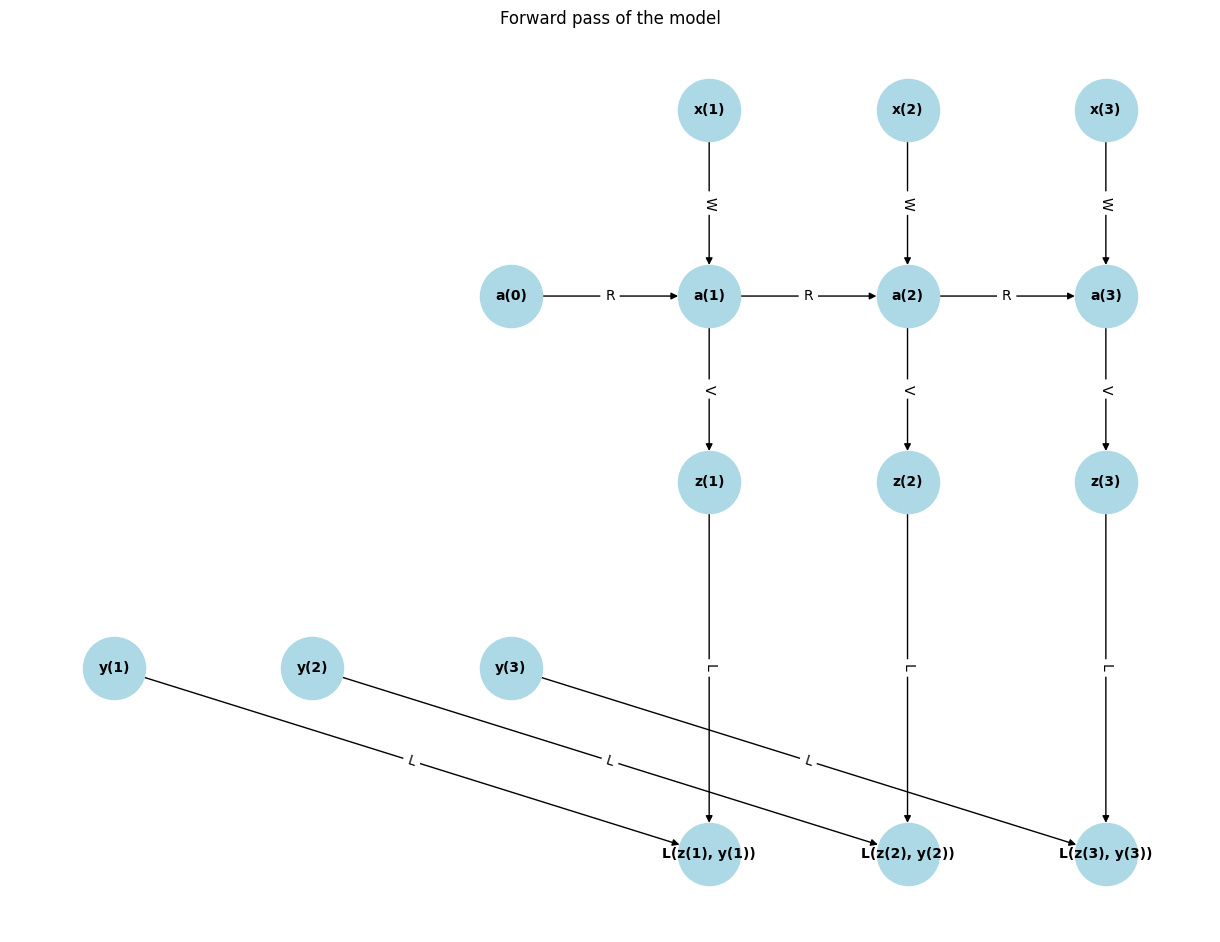

In [21]:
import networkx as nx
import matplotlib.pyplot as plt

########## YOUR SOLUTION HERE ##########

def plot(layers: list = [1, 2, 3]):
    G = nx.DiGraph()
    G.add_node('a(0)')
    for l in layers:
        # Nodes
        G.add_node(f"a({l})")
        G.add_node(f"x({l})")
        G.add_node(f"y({l})")
        G.add_node(f"z({l})")
        G.add_node(f"L(z({l}), y({l}))")

        # Connections, Loss
        G.add_edge(f"x({l})", f"a({l})", label="W")
        G.add_edge(f"a({l})", f"z({l})", label="V")
        G.add_edge(f"z({l})", f"L(z({l}), y({l}))", label="L")
        G.add_edge(f"y({l})", f"L(z({l}), y({l}))", label="L")
        G.add_edge(f"a({l-1})", f"a({l})", label="R")

    # a(0) separate
    G.add_edge(f"a(0)", f"a(1)", label="R")
    pos = {"a(0)" : (0, -1)}
    for l in layers:
        pos[f"x({l})"] = (l, 0)
        pos[f"a({l})"] = (l, -1)
        pos[f"z({l})"] = (l, -2)
        pos[f"y({l})"] = (l-3, -3)
        pos[f"L(z({l}), y({l}))"] = (l, -4)
    plt.figure(figsize=(4*len(layers), 3*len(layers)))
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color="lightblue", font_size=10, font_weight="bold")
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title("Forward pass of the model")
    plt.show()

plot([1, 2, 3])
